In [10]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [11]:
torch.manual_seed(111)

In [12]:
device = ""
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [13]:
device

device(type='cuda')

In [14]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))
    ]
)

In [21]:
trainSet = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

In [23]:
BATCH = 32
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=BATCH,
    shuffle=True
)

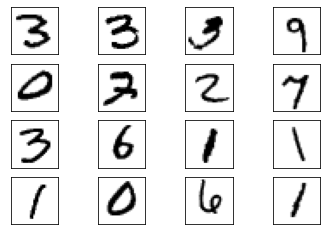

In [24]:
REAL, REAL_LABELS = next(iter(trainLoader))
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(REAL[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

In [25]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = x.view(x.size(0), 784)
    output = self.model(x)
    return output

In [30]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 784),
        nn.Tanh()
    )

  def forward(self, x):
    output = self.model(x)
    output = output.view(x.size(0), 1, 28, 28)
    return output

In [31]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [32]:
lr = 0.0001
EPOCHS = 50
LOSS = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [34]:
for epoch in range(EPOCHS):
  for n, (REAL, REAL_LABELS) in enumerate(trainLoader):

    #data for discriminator
    REAL = REAL.to(device=device)
    REAL_LABELS = torch.ones((BATCH, 1)).to(device=device)

    LATENT_SPACE = torch.randn((BATCH, 100)).to(device=device)

    GENERATED = generator(LATENT_SPACE)
    GENERATED_LABELS = torch.zeros((BATCH, 1)).to(device=device)

    ALL = torch.cat((REAL, GENERATED))
    ALL_LABELS = torch.cat((REAL_LABELS, GENERATED_LABELS))

    #training the discriminator
    discriminator.zero_grad()
    output_discriminator = discriminator(ALL)
    loss_discriminator = LOSS(output_discriminator, ALL_LABELS)
    loss_discriminator.backward()
    optimizer_discriminator.step()

    #data for generator
    LATENT_SPACE = torch.randn((BATCH, 100)).to(device=device)

    #training the generator
    generator.zero_grad()
    generated = generator(LATENT_SPACE)
    output_discriminator_generated = discriminator(generated)
    loss_generator = LOSS(output_discriminator_generated, REAL_LABELS)
    loss_generator.backward()
    optimizer_generator.step()

    if n==BATCH-1:
      print(f"EPOCH: {epoch} Loss D : {loss_discriminator}")
      print(f"EPOCH: {epoch} Loss G : {loss_generator}")

EPOCH: 0 Loss D : 0.5044265985488892
EPOCH: 0 Loss G : 0.5963003635406494
EPOCH: 1 Loss D : 0.04656662046909332
EPOCH: 1 Loss G : 4.147127628326416
EPOCH: 2 Loss D : 0.033033836632966995
EPOCH: 2 Loss G : 4.831940650939941
EPOCH: 3 Loss D : 0.01894242875277996
EPOCH: 3 Loss G : 7.684354782104492
EPOCH: 4 Loss D : 0.03933675214648247
EPOCH: 4 Loss G : 5.63691520690918
EPOCH: 5 Loss D : 0.11160387098789215
EPOCH: 5 Loss G : 3.373049259185791
EPOCH: 6 Loss D : 0.10157826542854309
EPOCH: 6 Loss G : 3.3620176315307617
EPOCH: 7 Loss D : 0.06777077168226242
EPOCH: 7 Loss G : 2.9960598945617676
EPOCH: 8 Loss D : 0.16389617323875427
EPOCH: 8 Loss G : 2.671438694000244
EPOCH: 9 Loss D : 0.26114875078201294
EPOCH: 9 Loss G : 3.3872365951538086
EPOCH: 10 Loss D : 0.2204897701740265
EPOCH: 10 Loss G : 2.796571731567383
EPOCH: 11 Loss D : 0.2999878525733948
EPOCH: 11 Loss G : 2.846165657043457
EPOCH: 12 Loss D : 0.2732633948326111
EPOCH: 12 Loss G : 1.5771280527114868
EPOCH: 13 Loss D : 0.3545129895

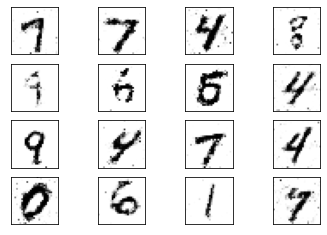

In [39]:
latent_space_samples = torch.randn(BATCH, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])